In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from tqdm import tqdm
import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import torch
from torch.distributions import MultivariateNormal
from sklearn.metrics import mean_pinball_loss
from autogluon.tabular import TabularDataset

import sbibm
from sbi.inference import SNPE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform
from lf2i.inference import LF2I
from lf2i.test_statistics import Waldo
from lf2i.test_statistics.posterior import Posterior
from lf2i.utils.other_methods import hpd_region
from lf2i.utils.miscellanea import to_np_if_pd
from lf2i.plot.parameter_regions import plot_parameter_region_2D
from lf2i.plot.coverage_diagnostics import coverage_probability_plot

from utils import posterior_and_prior_kdeplot, pinball_loss_heatmap

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
POI_DIM = 2  # parameter of interest

B = 100_000  # num simulations to estimate posterior and test statistics
B_PRIME = 100_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 30_000  # num simulations over which to check coverage probability
EVAL_GRID_SIZE = 50_000  # num evaluation points over parameter space to construct confidence sets

CONFIDENCE_LEVEL = 0.9
TEST_STATISTIC = 'Posterior'

FLOW_TYPE = 'maf'
NORM_POSTERIOR_SAMPLES = None

In [5]:
task = sbibm.get_task('gaussian_mixture')
simulator = task.get_simulator()

In [6]:
PRIOR_LOC = [0, 0]
PRIOR_VAR = 2.0

prior = MultivariateNormal(
    loc=torch.Tensor(PRIOR_LOC), covariance_matrix=PRIOR_VAR*torch.eye(n=POI_DIM)
)

## Posterior

In [7]:
b_params = prior.sample(sample_shape=(B, ))
b_samples = simulator(b_params)

estimator = SNPE(prior=prior, density_estimator=FLOW_TYPE)
_ = estimator.append_simulations(b_params, b_samples).train()
posterior = estimator.build_posterior()

 Neural network successfully converged after 112 epochs.

In [8]:
with open('./outputs/maf_gmm_gaussPrior.pkl', 'wb') as f:
    pickle.dump(posterior, f)

In [7]:
with open('./outputs/maf_gmm_gaussPrior.pkl', 'rb') as f:
    posterior = pickle.load(f)

In [27]:
idx_obs = 1
true_theta, true_x = task.get_true_parameters(idx_obs), task.get_observation(idx_obs)

samples_posterior = posterior.sample((100_000,), x=true_x)
samples_prior = prior.sample(sample_shape=(100_000, ))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

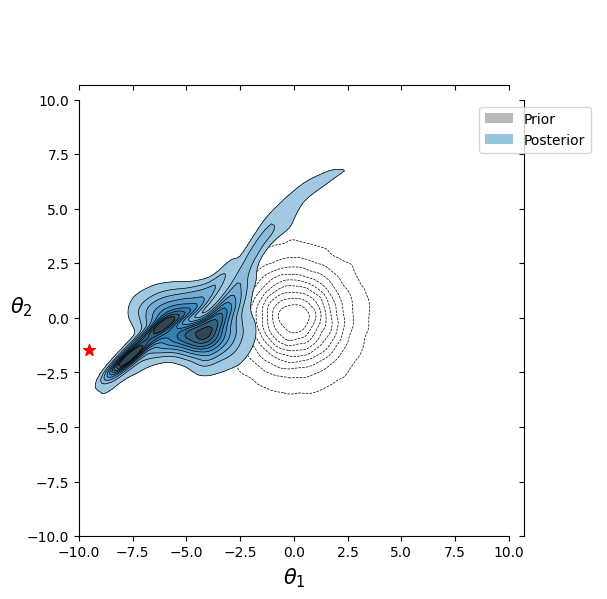

In [28]:
posterior_and_prior_kdeplot(
    samples_prior, samples_posterior, true_theta, plot_marginals=False
)

In [13]:
idx_obs = 1
true_theta = task.get_true_parameters(idx_obs)
true_theta

tensor([[-9.5271, -1.4817]])

In [26]:
true_x = simulator(true_theta)
true_x

tensor([[-9.4871, -1.4303]])

In [27]:
samples_posterior = posterior.sample((100_000,), x=true_x)
samples_prior = prior.sample(sample_shape=(100_000, ))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

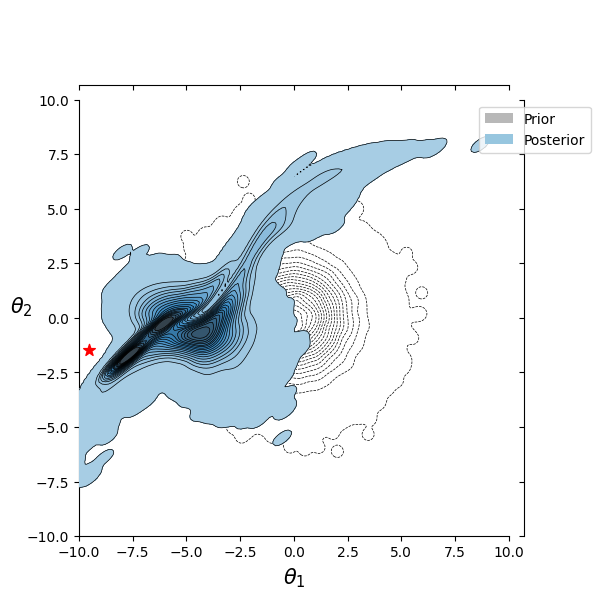

In [28]:
posterior_and_prior_kdeplot(
    samples_prior, samples_posterior, true_theta, plot_marginals=False, levels=20, thresh=0.0001
)

## LF2I

In [8]:
# used to sample simulations for quantile regression and for evaluation grid
reference = BoxUniform(low=torch.Tensor([-10, -10]), high=torch.Tensor([10, 10]))
eval_grid = reference.sample(sample_shape=(EVAL_GRID_SIZE, ))

b_prime_params = reference.sample(sample_shape=(B_PRIME, ))
b_prime_samples = simulator(b_prime_params)
b_prime_params.shape, b_prime_samples.shape

(torch.Size([100000, 2]), torch.Size([100000, 2]))

#### CAT-GB

In [9]:
lf2i_catgb = LF2I(
    test_statistic=Posterior(
        poi_dim=POI_DIM, estimator=posterior, norm_posterior_samples=NORM_POSTERIOR_SAMPLES
    )
)

In [10]:
confidence_sets_catgb = lf2i_catgb.inference(
    x=torch.vstack([task.get_observation(i) for i in range(1, 11)]),  # each task contains 10 benchmark observations
    evaluation_grid=eval_grid,
    confidence_level=CONFIDENCE_LEVEL,
    calibration_method='critical-values',
    calibration_model='cat-gb',
    calibration_model_kwargs={
        'cv': {'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 9]},
        'n_iter': 25
    },
    T_prime=(b_prime_params, b_prime_samples),
    retrain_calibration=False
)


Calibration ...


Evaluating posterior for 100000 points ...:   0%|          | 0/100000 [00:00<?, ?it/s]WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Evaluating posterior for 100000 points ...: 100%|██████████| 100000/100000 [00:22<00:00, 4495.5

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Constructing confidence regions ...


Evaluating posterior for 10 points ...: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s]


#### AUTOGLUON

In [38]:
lf2i_autogluon = LF2I(
    test_statistic=Posterior(
        poi_dim=POI_DIM, estimator=posterior, norm_posterior_samples=NORM_POSTERIOR_SAMPLES
    )
)

In [39]:
confidence_sets_autogluon = lf2i_autogluon.inference(
    x=torch.vstack([task.get_observation(i) for i in range(1, 11)]),  # each task contains 10 benchmark observations
    evaluation_grid=eval_grid,
    confidence_level=CONFIDENCE_LEVEL,
    calibration_method='critical-values',
    calibration_model='autogluon',
    calibration_model_kwargs={
        'presets': 'best_quality', 'verbosity': 3
    },
    T_prime=(b_prime_params, b_prime_samples),
    retrain_calibration=False
)


Calibration ...


Evaluating posterior for 30000 points ...:   0%|          | 0/30000 [00:00<?, ?it/s]WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Evaluating posterior for 30000 points ...: 100%|██████████| 30000/30000 [00:18<00:00, 1666.07it/s


Constructing confidence regions ...


Evaluating posterior for 10 points ...:   0%|          | 0/10 [00:00<?, ?it/s]WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Evaluating posterior for 10 points ...: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]
Loading: Autogl

## Analysis

In [10]:
eval_samples = simulator(eval_grid)
eval_samples.shape, eval_grid.shape

(torch.Size([50000, 2]), torch.Size([50000, 2]))

In [11]:
def pinball_loss(y_true, y_pred, alpha):
    loss = np.where(y_true >= y_pred, alpha * np.abs(y_true - y_pred), (1 - alpha) * np.abs(y_true - y_pred))
    return loss

#### CATGB

In [12]:
true_test_stats = lf2i_catgb.test_statistic.evaluate(eval_grid, eval_samples, 'critical_values').reshape(-1, )
pred_cv_catgb = lf2i_catgb.calibration_model[f'{CONFIDENCE_LEVEL:.2f}'].predict(eval_grid.numpy()).reshape(-1, )

catgb_eval_loss = pinball_loss(
    y_true=true_test_stats, y_pred=pred_cv_catgb, alpha=1-CONFIDENCE_LEVEL if TEST_STATISTIC == 'Posterior' else '????'
)

Evaluating posterior for 50000 points ...: 100%|██████████| 50000/50000 [00:05<00:00, 9025.49it/s] 


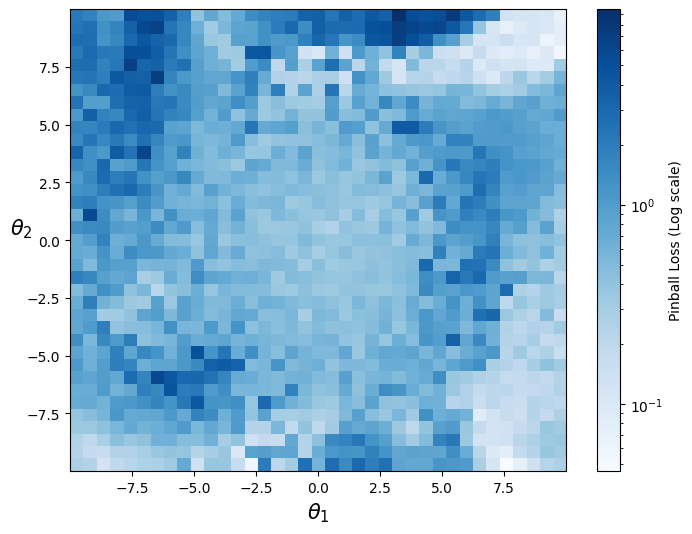

In [13]:
pinball_loss_heatmap(
    eval_grid, catgb_eval_loss
)

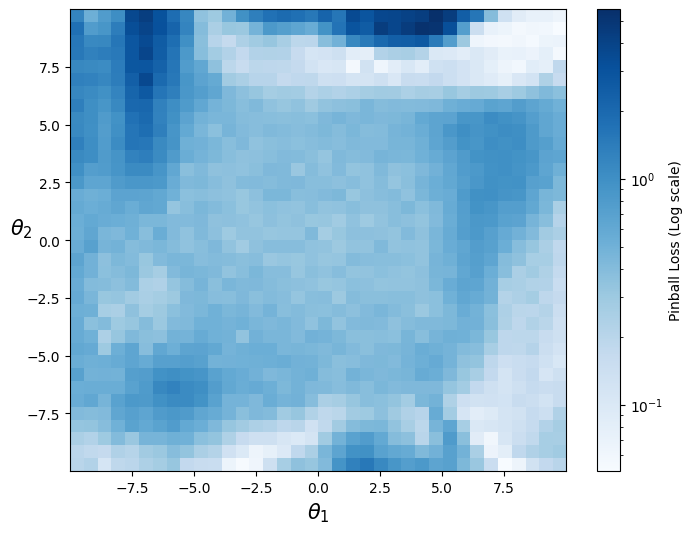

In [14]:
pinball_loss_heatmap(
    eval_grid[true_test_stats.reshape(-1, ) >= pred_cv_catgb.reshape(-1, ), :], 
    catgb_eval_loss[true_test_stats.reshape(-1, ) >= pred_cv_catgb.reshape(-1, )]
)

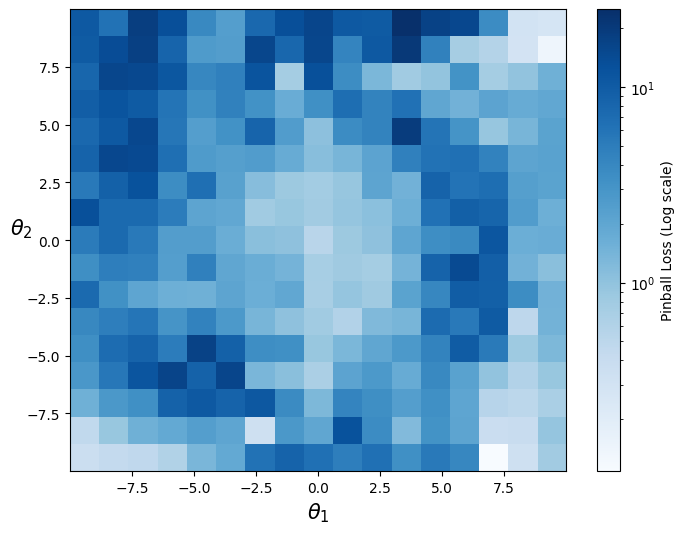

In [15]:
pinball_loss_heatmap(
    eval_grid[true_test_stats.reshape(-1, ) < pred_cv_catgb.reshape(-1, ), :], 
    catgb_eval_loss[true_test_stats.reshape(-1, ) < pred_cv_catgb.reshape(-1, )]
)

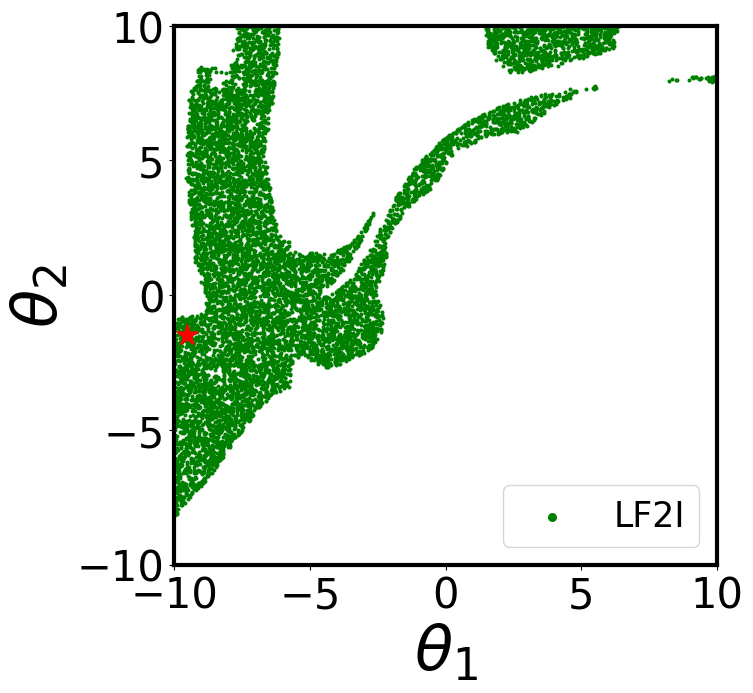

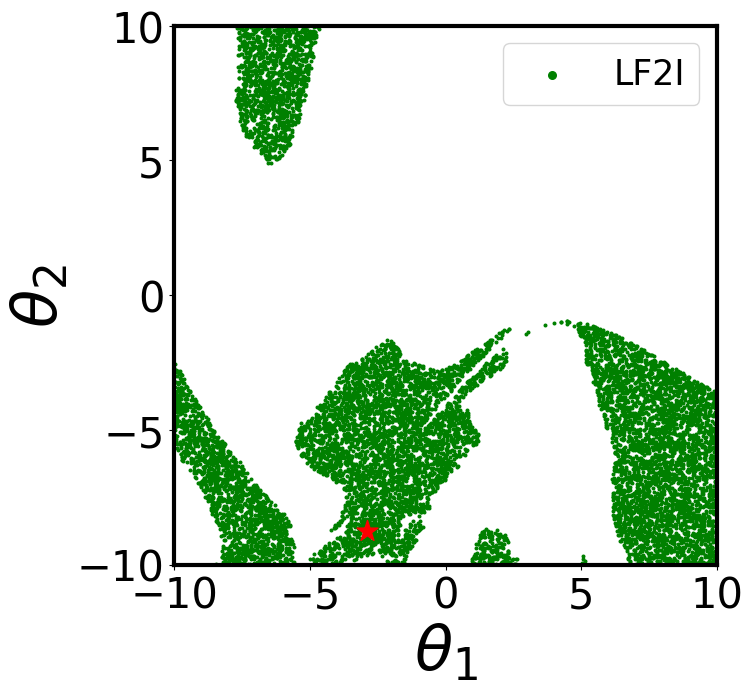

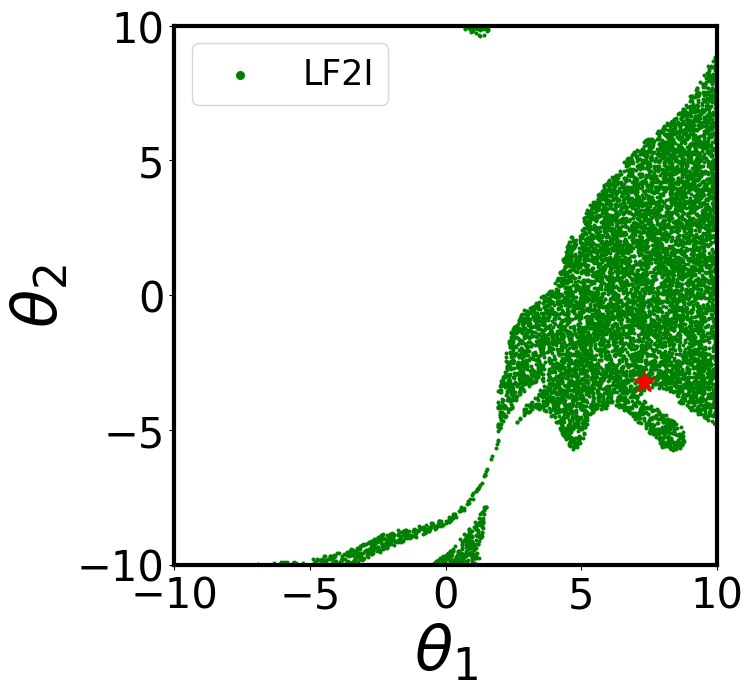

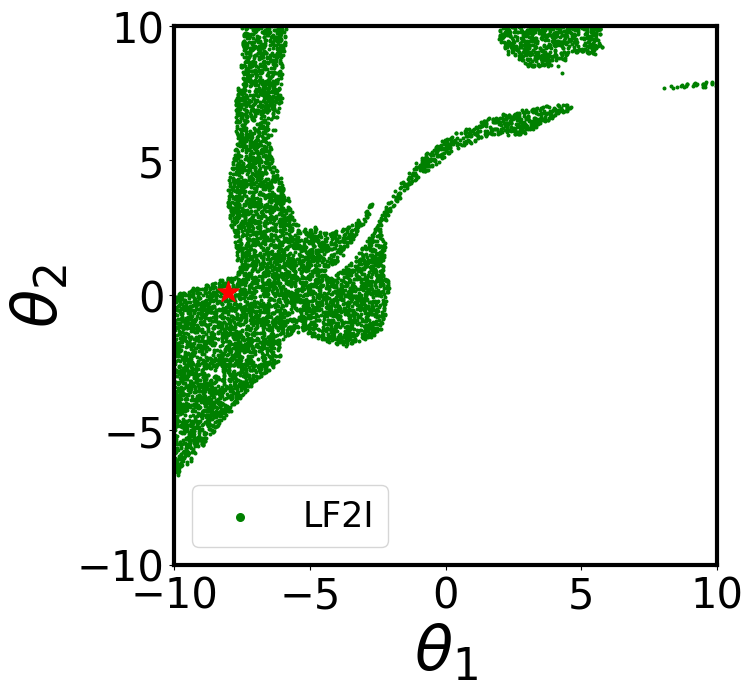

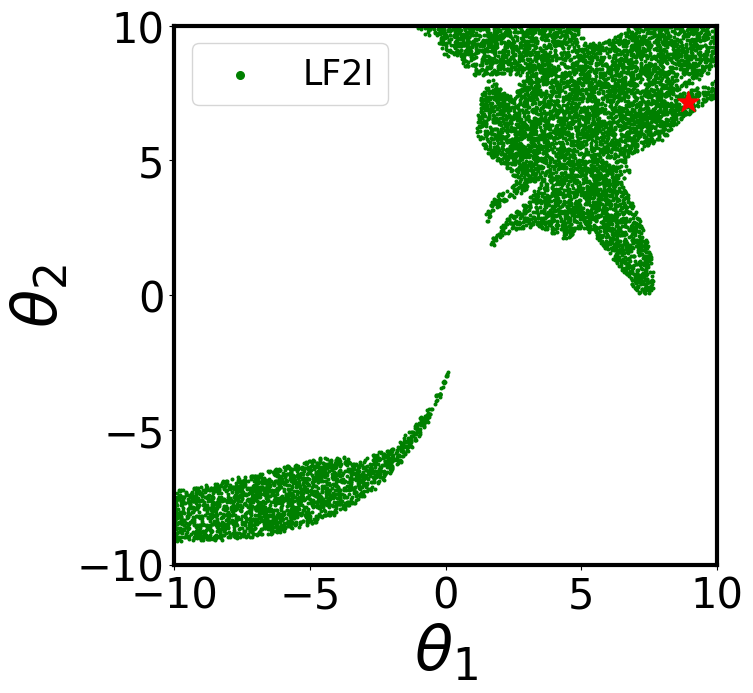

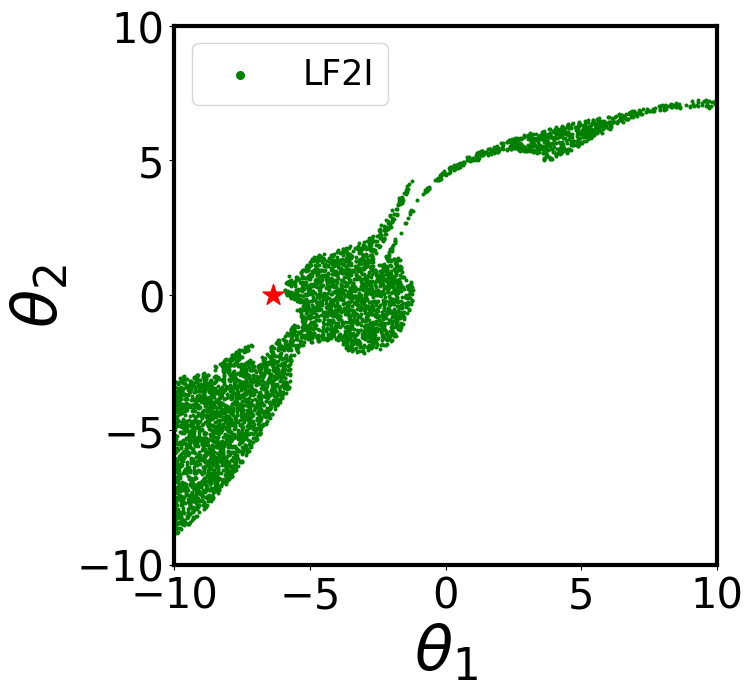

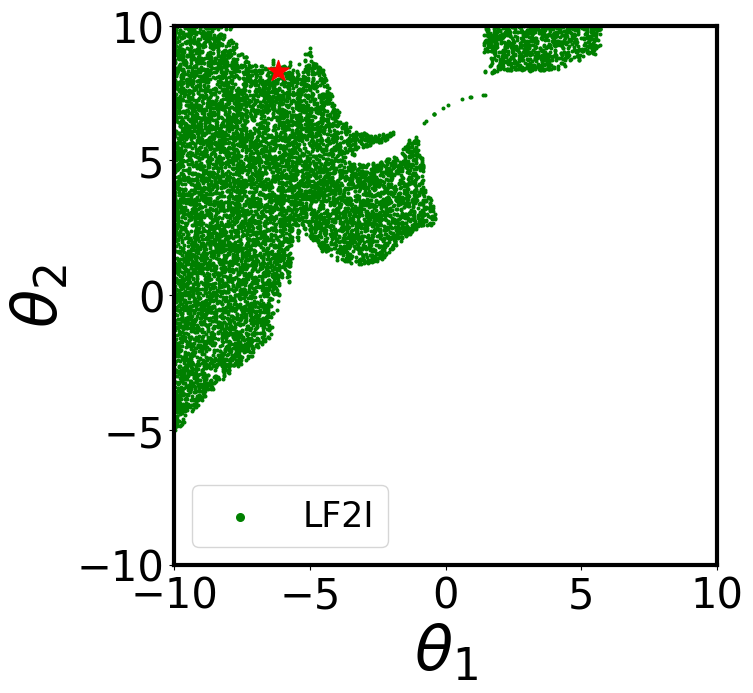

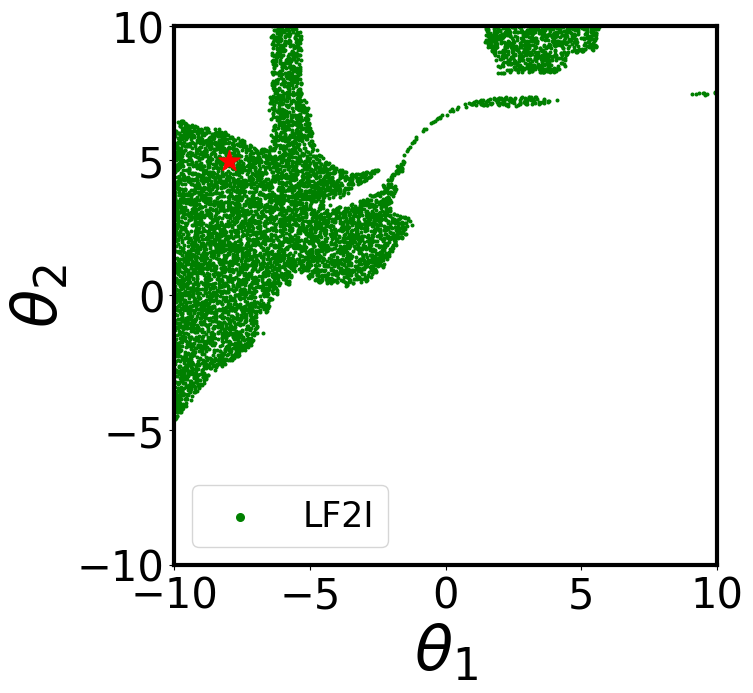

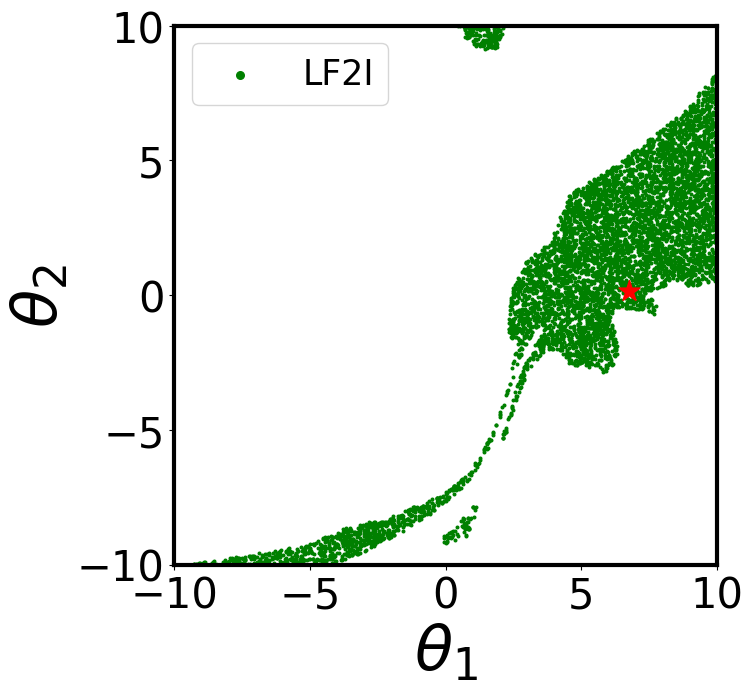

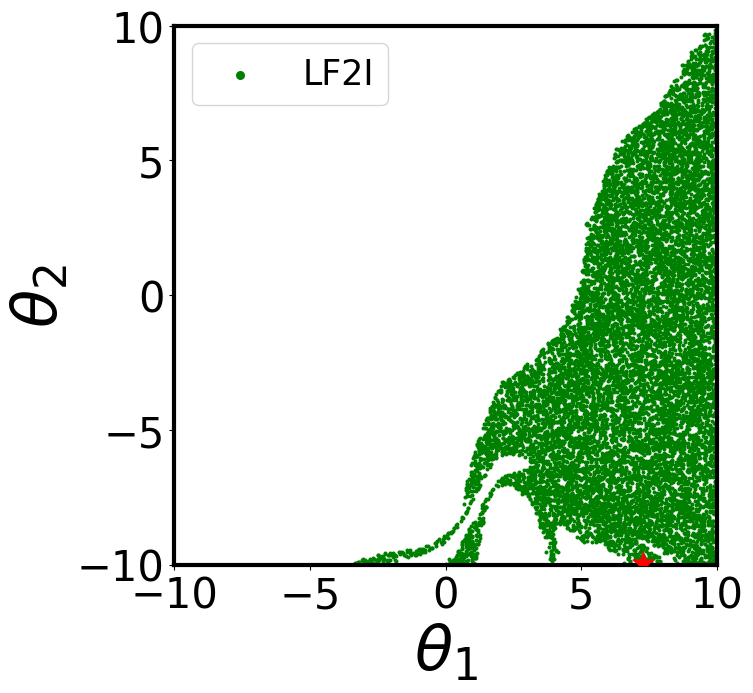

In [11]:
for idx_obs in range(10):
    plot_parameter_region_2D(
        parameter_region=confidence_sets_catgb[idx_obs],
        true_parameter=task.get_true_parameters(idx_obs+1),
        labels=[r'$\theta_1$', r'$\theta_2$'],
        param_names=[r'$\theta_1$', r'$\theta_2$'],
        parameter_space_bounds={r'$\theta_1$': {'low': -10, 'high': 10}, r'$\theta_2$': {'low': -10, 'high': 10}},
        alpha_shape=False,
        scatter=True,
        region_name='LF2I',
        figsize=(7, 7)
    )

#### AUTOGLUON

In [42]:
true_test_stats = lf2i_autogluon.test_statistic.evaluate(eval_grid, eval_samples, 'critical_values').reshape(-1, )
pred_cv_autogluon = to_np_if_pd(lf2i_autogluon.calibration_model[f'{CONFIDENCE_LEVEL:.2f}'].predict(
    TabularDataset(data=pd.DataFrame(eval_grid.numpy(), columns=[f'feature{i+1}' for i in range(eval_grid.shape[1])]))
)).reshape(-1, )

autogluon_eval_loss = pinball_loss(
    y_true=true_test_stats, y_pred=pred_cv_autogluon, alpha=1-CONFIDENCE_LEVEL if TEST_STATISTIC == 'Posterior' else '????'
)

Evaluating posterior for 50000 points ...:   0%|          | 0/50000 [00:00<?, ?it/s]WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Evaluating posterior for 50000 points ...: 100%|██████████| 50000/50000 [00:22<00:00, 2268.25it/s

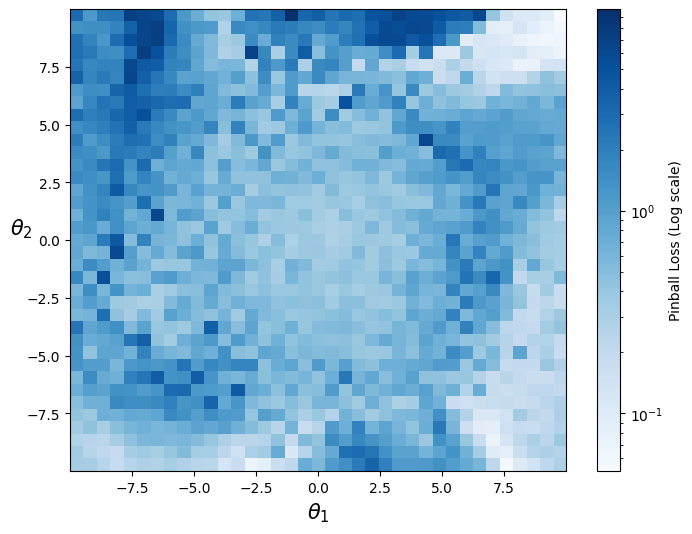

In [43]:
pinball_loss_heatmap(
    eval_grid, autogluon_eval_loss
)

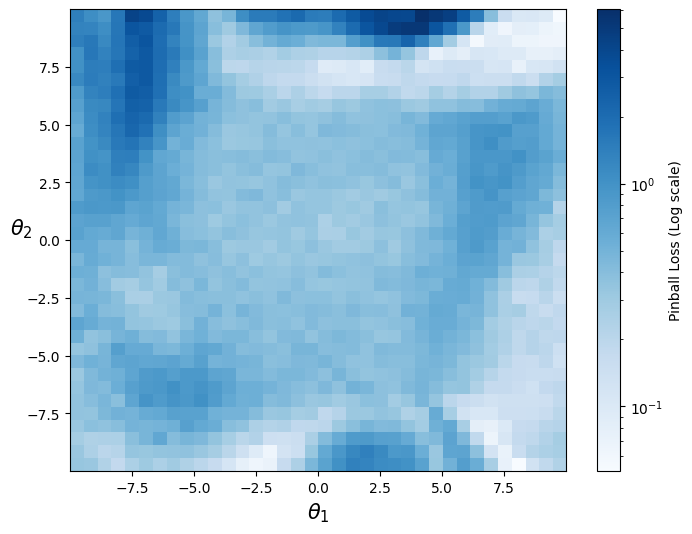

In [44]:
pinball_loss_heatmap(
    eval_grid[true_test_stats.reshape(-1, ) >= pred_cv_autogluon.reshape(-1, ), :], 
    autogluon_eval_loss[true_test_stats.reshape(-1, ) >= pred_cv_autogluon.reshape(-1, )]
)

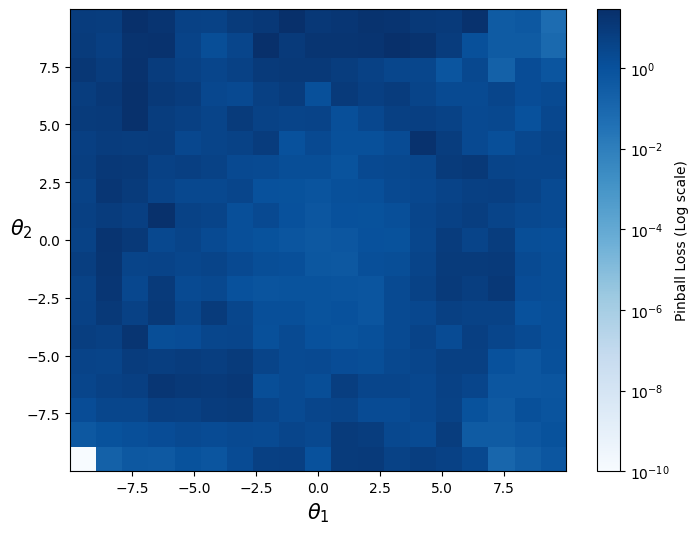

In [45]:
pinball_loss_heatmap(
    eval_grid[true_test_stats.reshape(-1, ) < pred_cv_autogluon.reshape(-1, ), :], 
    autogluon_eval_loss[true_test_stats.reshape(-1, ) < pred_cv_autogluon.reshape(-1, )]
)

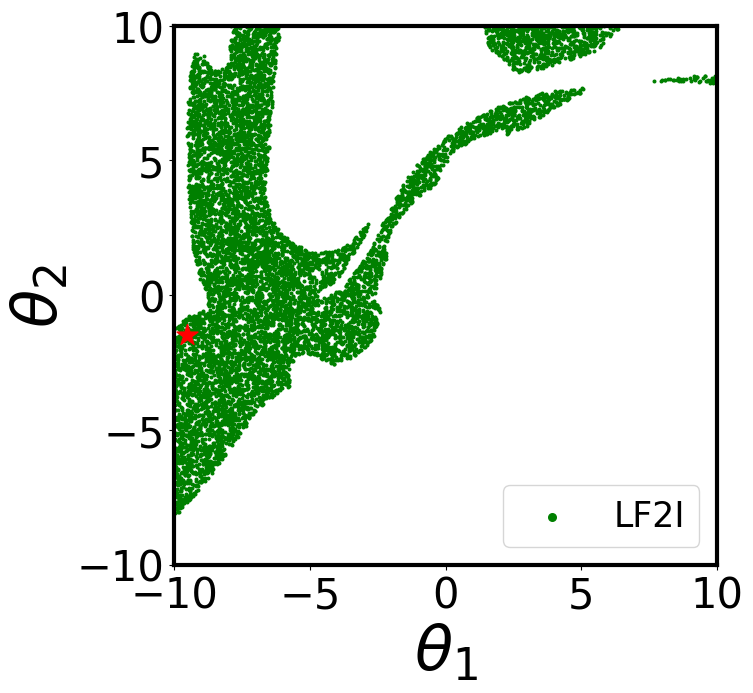

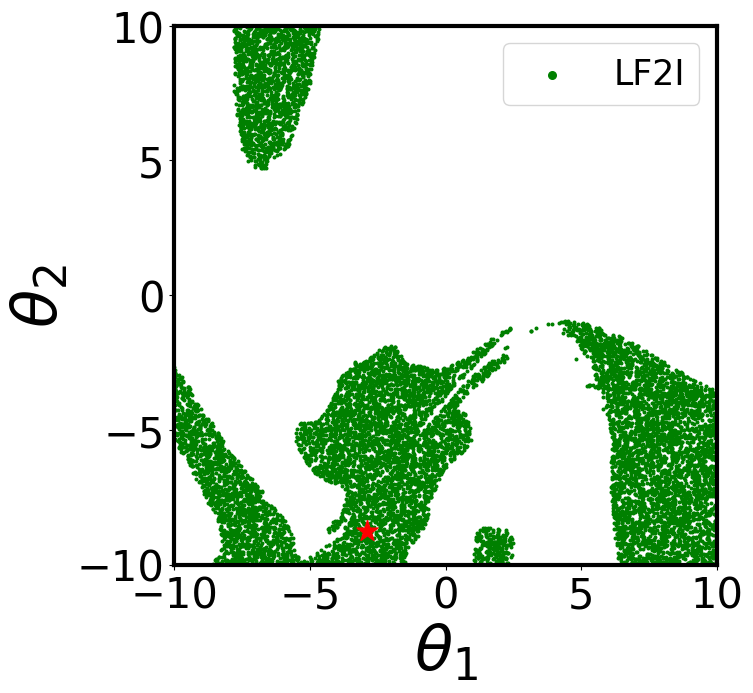

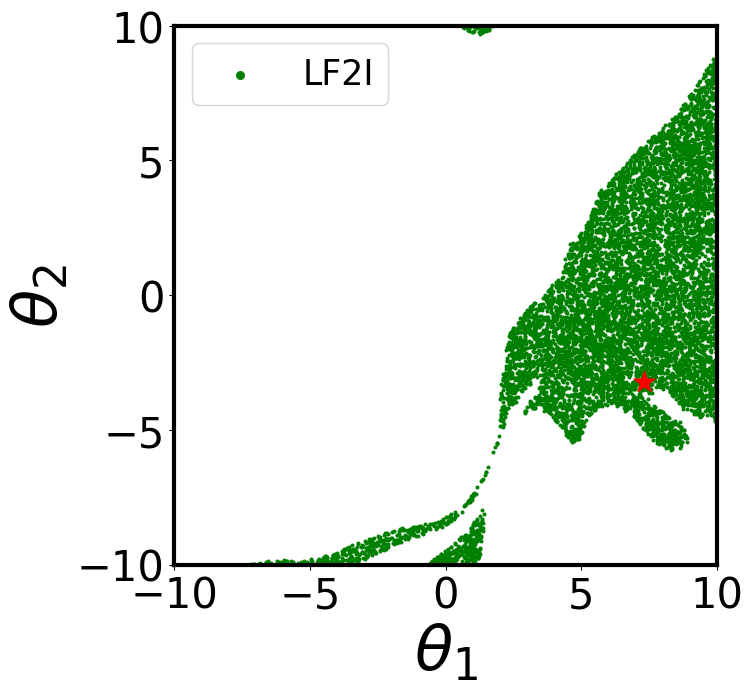

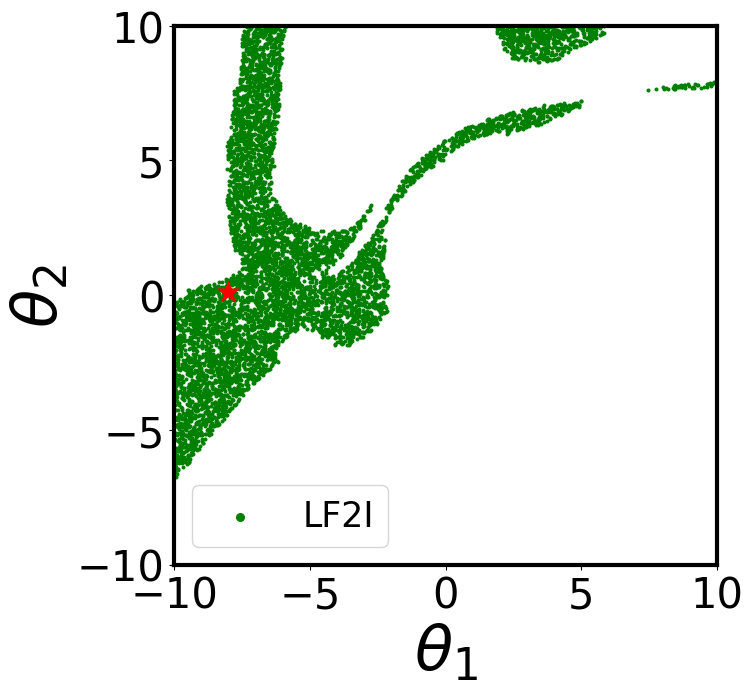

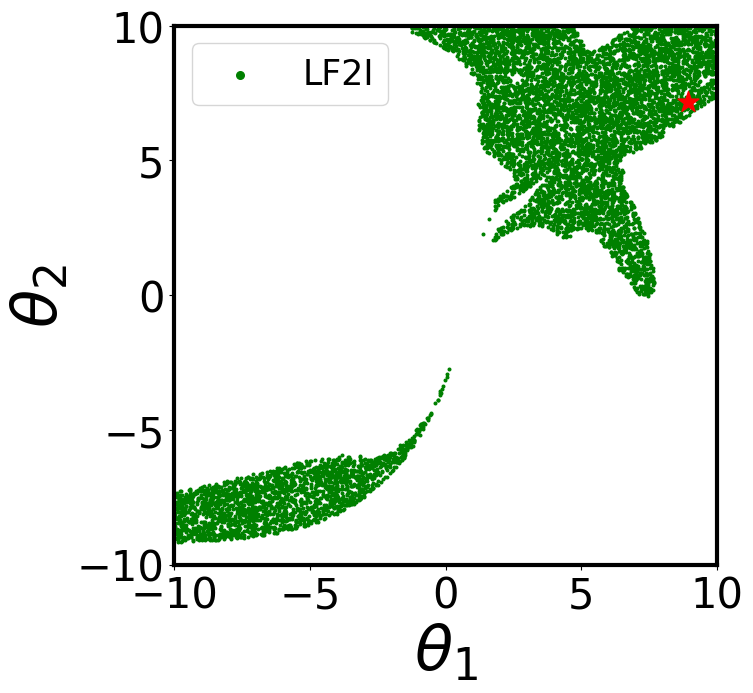

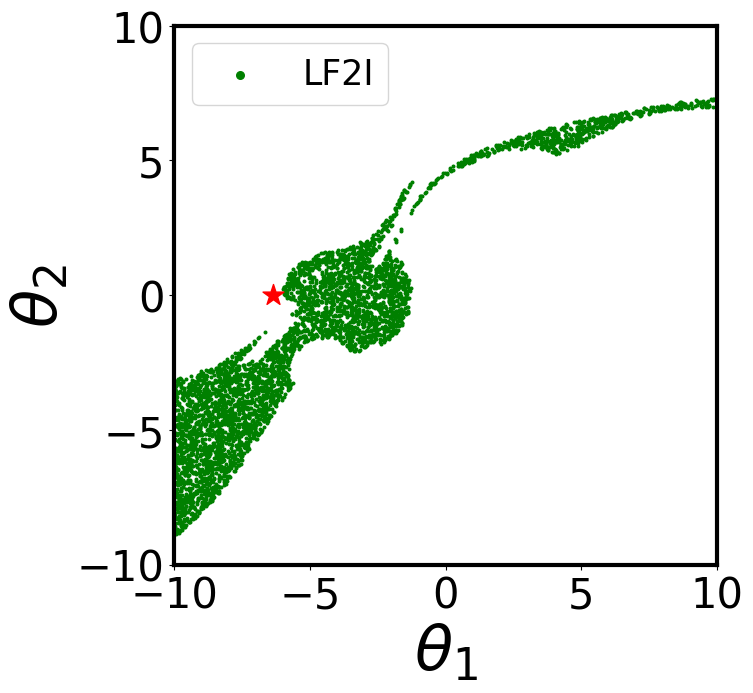

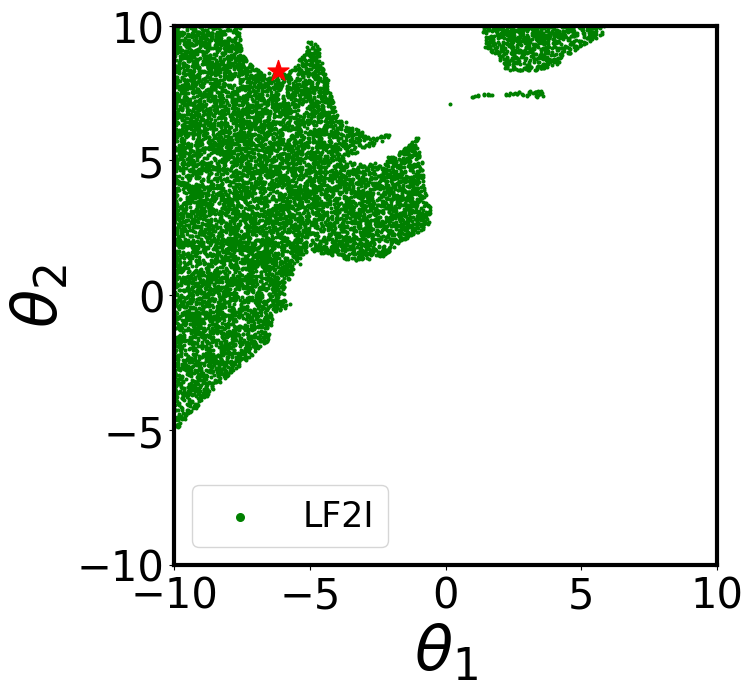

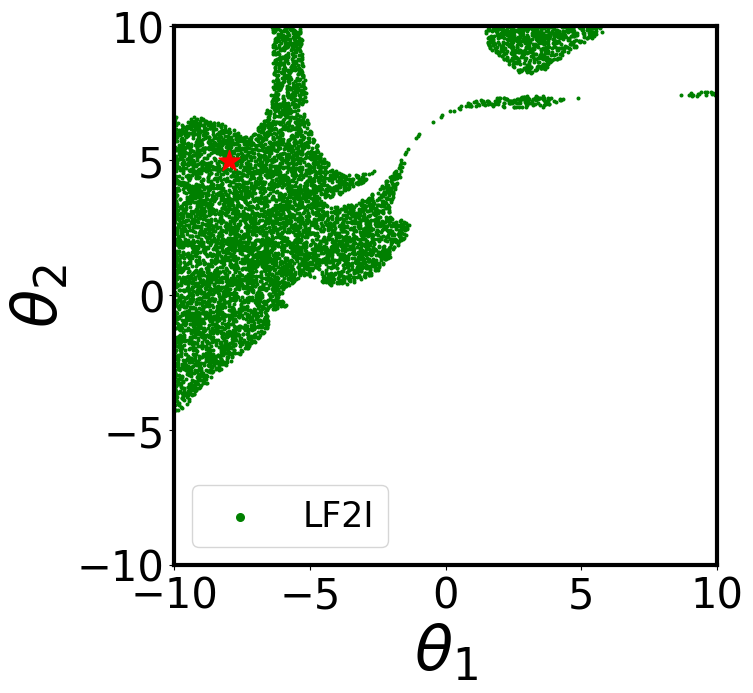

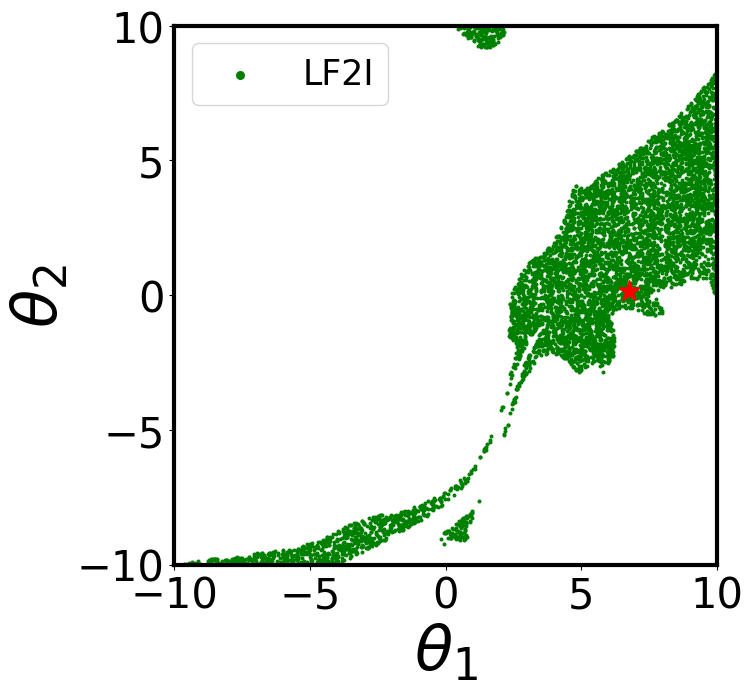

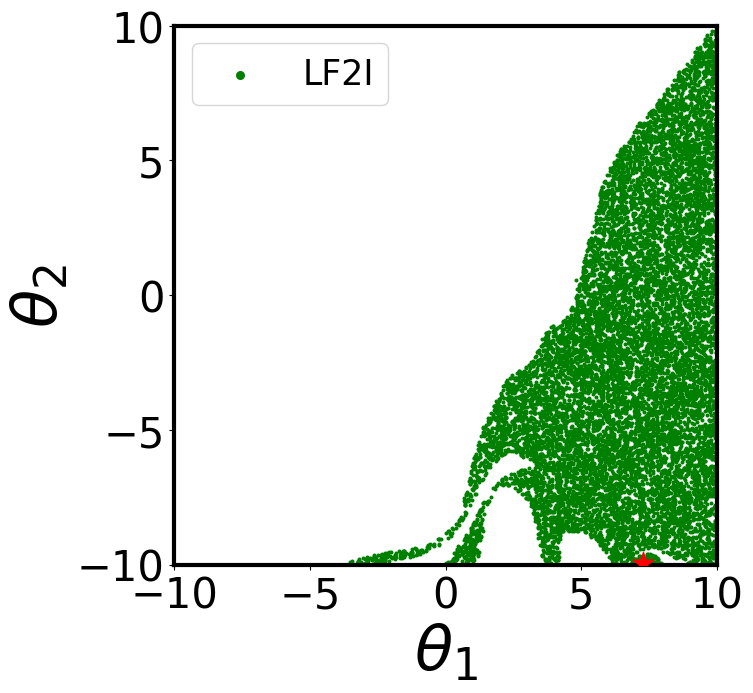

In [48]:
for idx_obs in range(10):
    plot_parameter_region_2D(
        parameter_region=confidence_sets_autogluon[idx_obs],
        true_parameter=task.get_true_parameters(idx_obs+1),
        labels=[r'$\theta_1$', r'$\theta_2$'],
        param_names=[r'$\theta_1$', r'$\theta_2$'],
        parameter_space_bounds={r'$\theta_1$': {'low': -10, 'high': 10}, r'$\theta_2$': {'low': -10, 'high': 10}},
        alpha_shape=False,
        scatter=True,
        region_name='LF2I',
        figsize=(7, 7)
    )